# I- Corrélation entre attributs et suppression manuelle de quelques features


## installation des lib

In [ ]:
%pip install plotly

In [ ]:
%pip install yellowbrick

In [ ]:
%pip install pandas

In [ ]:
%pip install matplotlib

In [ ]:
%pip install jinja2

In [ ]:
%pip install scikit-learn

In [ ]:
%pip install seaborn

In [36]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

## transformation des vars

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72872 entries, 0 to 72871
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Num_Acc                   72872 non-null  int64  
 1   num_veh                   72872 non-null  int32  
 2   id_usa                    72872 non-null  int64  
 3   date                      72872 non-null  int64  
 4   ville                     72872 non-null  int32  
 5   id_code_insee             72872 non-null  int32  
 6   latitude                  72872 non-null  float64
 7   longitude                 72872 non-null  float64
 8   descr_cat_veh             72872 non-null  int64  
 9   descr_agglo               72872 non-null  int32  
 10  descr_athmo               72872 non-null  int32  
 11  descr_lum                 72872 non-null  int32  
 12  descr_etat_surf           72872 non-null  int32  
 13  description_intersection  72872 non-null  int32  
 14  an_nai

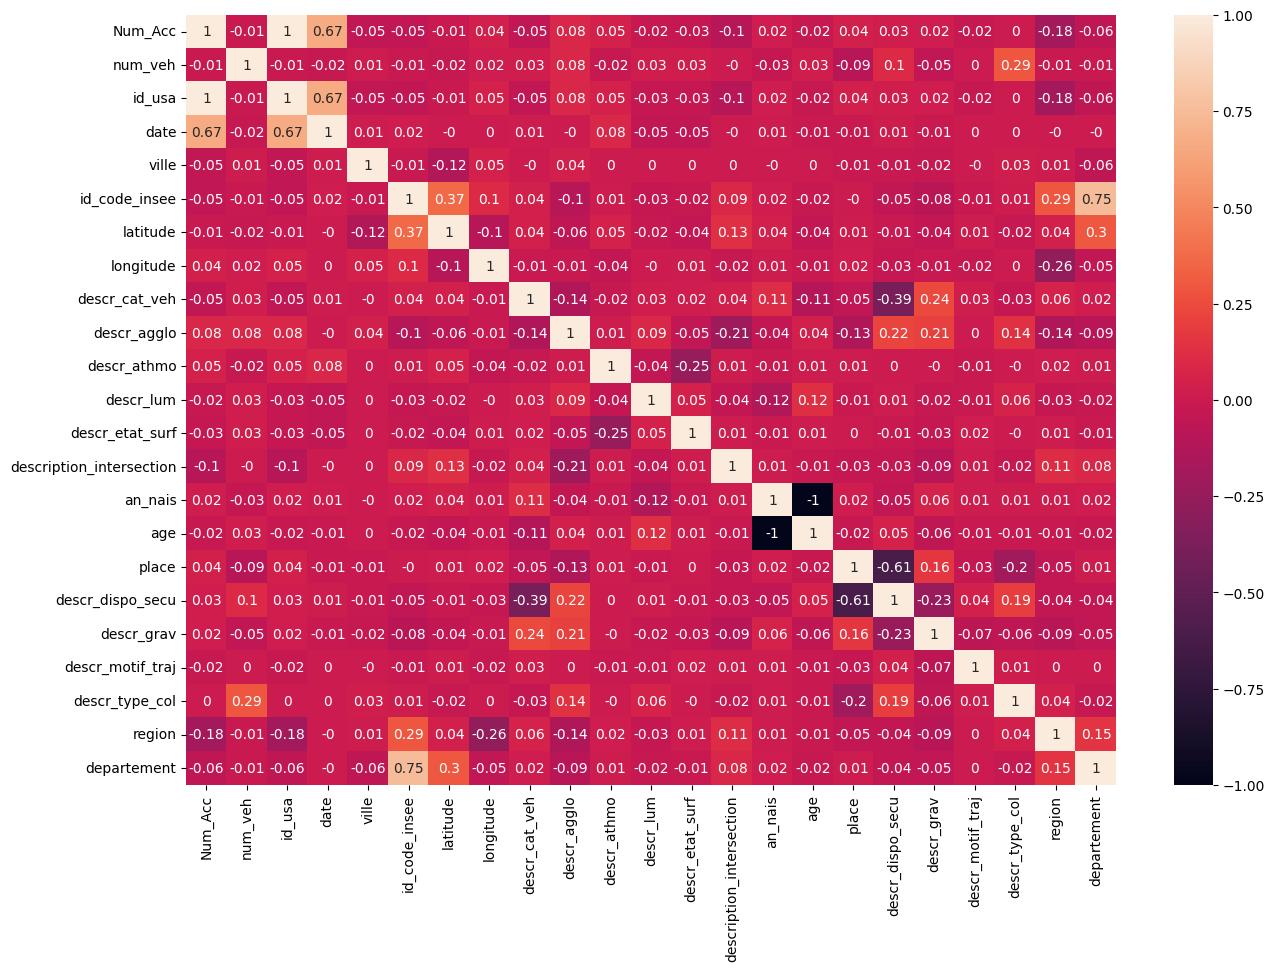

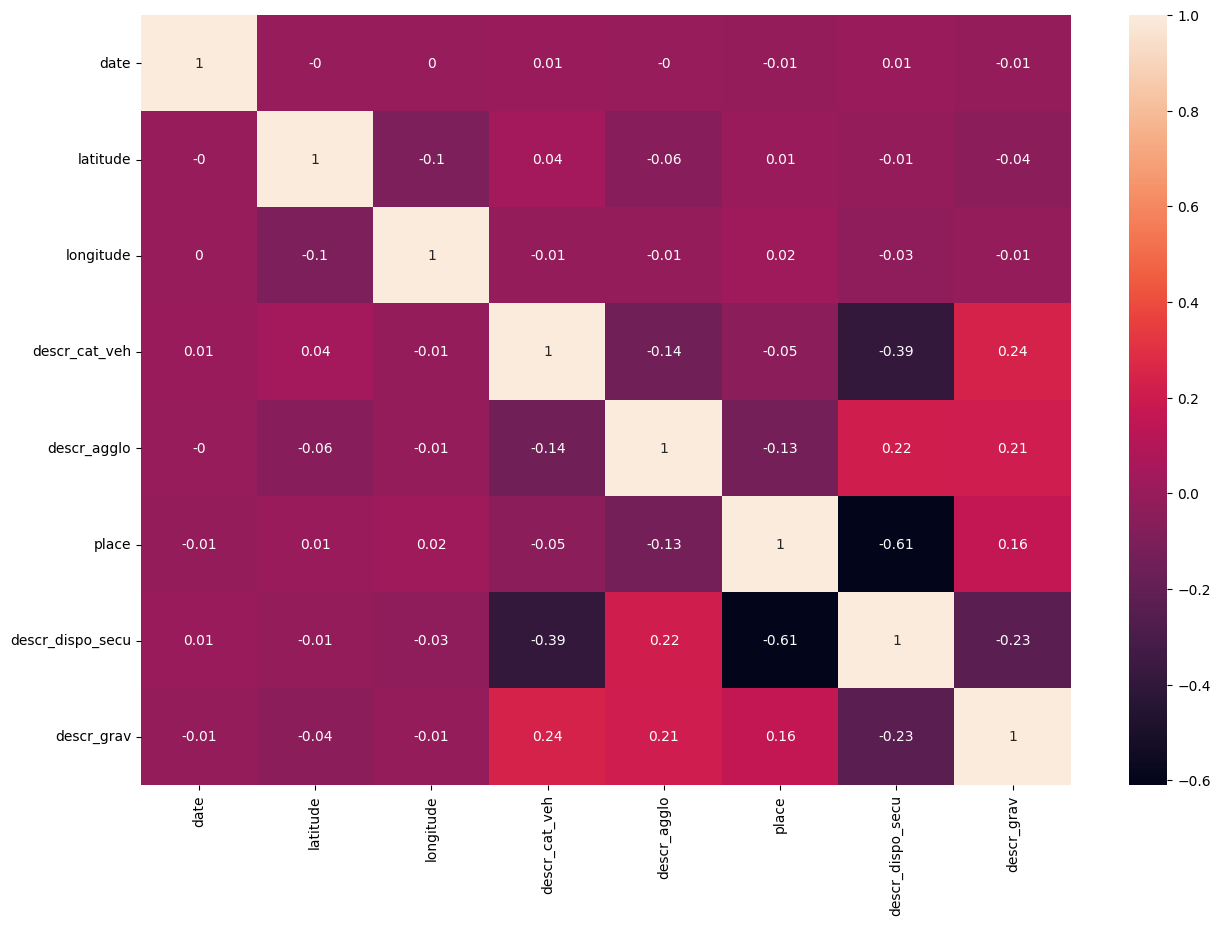

In [37]:
df = pd.read_csv('../df.csv')

enc = preprocessing.LabelEncoder()


#convertit en numérique les colonnes et évite de convertir les colonnes latitude et longitude pour garder les bonnes valeur pour les graphiques
for column_name in df:
    if column_name != 'longitude' and column_name != 'latitude':
        if not column_name.isnumeric()  :
            df[column_name] = enc.fit_transform(df[column_name])


df.info()
df
#matrice de correlation
corr_df = df.corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(round(corr_df,2), annot=True)
plt.xticks(rotation=90)
plt.show()

#supprimer colonne
del df['Num_Acc']
del df['num_veh']
del df['id_usa']
del df['ville']
del df['id_code_insee']
del df['descr_athmo']
del df['descr_lum']
del df['descr_etat_surf']
del df['description_intersection']
del df['an_nais']
del df['age']
del df['descr_motif_traj']
del df['descr_type_col']
del df['region']
del df['departement']

#nouvelle matrice de correlation prenant en compte les colonnes supprimées pour n'afficher que le reste
corr_df = df.corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(round(corr_df,2), annot=True)
plt.xticks(rotation=90)
plt.show()
#del df['nom colonne']


df.to_csv("../dfClean.csv",sep=",",index=False)

# Partionnement ( Clustering )

## k-means from scikit-learn

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import yellowbrick
#évite d'avoir des couleurs ternes dû à yellowbrick
yellowbrick.style.rcmod.reset_defaults()


def sklearn_clustering(data, n_clusters):
    # dictionnaire pour stocker les résultats des clusters
    results = {}
    all_labels = []
    
    # effectue le clustering pour chaque nombre de clusters
    for n in n_clusters:
        labels = []
        # définit le modèle k-means
        kmeans = KMeans(n_clusters=n, random_state=42)
        # effectue le clustering
        kmeans.fit(data)
        # assigne les clusters aux points de donnée
        labels = kmeans.labels_
        #obtention des coordonnées des centroïdes
        centroids = kmeans.cluster_centers_
        # stocke les résultats des clusters
        results[n] = {'labels': labels, 'centroids': centroids}
        all_labels.append(labels)
    
    # affichage des résultats des clusters pour chaque nombre de clusters
    for n, result in results.items():
        labels = result['labels']
        centroids = result['centroids']
        
        # affiche le résultat du clustering
        plt.scatter(data['longitude'], data['latitude'], c=labels)
        plt.scatter(centroids[:, 1], centroids[:, 0], marker='x', color='red')
        plt.title(f"Clustering with {n} clusters")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()
    return all_labels,centroids

data = df[['latitude', 'longitude']]
n_clusters = [2, 3, 4, 5, 6]

all_labels,centroids = sklearn_clustering(data, n_clusters)
print(all_labels,centroids)


## k-means from scratch

In [40]:
import matplotlib.pyplot as plt

In [41]:
from math import floor
import numpy as np


def naiveShard(df, k):
    
    n = df.shape[1]
    m = df.shape[0]
    centroidf = np.mat(np.zeros((k, n)))

    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(df.sum(axis=1))
    df = np.append(composite.T, df, axis=1)
    df.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m / k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shardf)
    # Sum columns of shardf, get means; these columnar means are centroidf
    for j in range(k):
        if j == k - 1:
            centroidf[j:] = vfunc(np.sum(df[j * step:, 1:], axis=0), step)
        else:
            centroidf[j:] = vfunc(np.sum(df[j * step:(j + 1) * step, 1:], axis=0), step)

    return centroidf

def _get_mean(sums, step):
    return sums / step


In [42]:
def getMean(coords):
    num_coords = len(coords)
    sum_x = sum(x[0] for x in coords)
    sum_y = sum(y[1] for y in coords)
    mean_x = sum_x / num_coords
    mean_y = sum_y / num_coords

    return mean_x, mean_y

In [43]:
import sklearn.preprocessing
def Kmeans(NbCentroids,daf):
    clusterList = [[] for _ in range(NbCentroids)]
    daf = daf[['latitude','longitude']]

    #on va utiliser la méthode par naive sharding
    minmax_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    X_scaled = minmax_scaler.fit_transform(daf)
    centroids = naiveShard(X_scaled, k=NbCentroids)
    centroids = minmax_scaler.inverse_transform(np.array(centroids))
    difference = 10
    #pour chaque accident on regarde quel est le centroide le plus proche
    while difference > 0.4:
        for index, row in daf.iterrows():
            pt = [row['latitude'],row['longitude']]
            distlist = [[] for _ in range(NbCentroids)]
            for i in range(len(centroids)):
                distlist[i] = np.linalg.norm(np.array(pt) - centroids[i]) #dist eucl*
            min_index = distlist.index(min(distlist))
            clusterList[min_index].append(pt)
    #on regarde en faisant la moy. du cluster, si on obtient un centroid assez proche
        newCentroids = []
        for e in clusterList:
            newCentroids.append(getMean(e))
        difference = np.linalg.norm(np.array(newCentroids) - centroids)
        print(difference)
        if difference > 0.4:
            centroids = np.array(newCentroids)
            clusterList = [[] for _ in range(NbCentroids)]
    
    return clusterList,centroids

In [44]:
a = Kmeans(13,data)

5.920170867320352
2.618678907188294
0.9080841390561776
0.5834547989611518
0.4633179483984414
0.3724138518104459


### Le créateur de csv pour les scripts

In [45]:
import json
clusterList = a[0]
file_path = '../jsons/data/dictCluster.json'

#pour faciliter l'utilisation des données je vais transformer cette liste en dictionnaire ( plus adapté au format json)
dictCluster = {}

for index, value in enumerate(clusterList):
    print(value)
    dictCluster[index] = (value)

# on va venir écrire un nouveau fichier
with open(file_path, 'w') as file:
    json.dump(dictCluster, file)


[[47.4833, -1.23333], [48.2833, -4.05], [48.1667, -3.78333], [47.9333, -1.6], [47.8167, -1.95], [47.8167, -1.95], [47.7, -2.0], [47.7, -2.0], [47.35, -0.85], [47.7833, -3.41667], [47.6833, -2.55], [47.5333, -2.76667], [47.5333, -2.76667], [47.5333, -1.88333], [47.1667, -1.26667], [47.6333, -2.13333], [46.7833, -2.06667], [46.7833, -2.06667], [48.0667, -0.933333], [48.0667, -0.633333], [47.25, -2.16667], [48.5167, -2.78333], [47.9833, -4.18333], [48.65, -2.01667], [48.0833, -1.68333], [48.0833, -1.68333], [47.1167, -2.1], [47.35, -0.85], [47.7833, -3.41667], [47.8167, -2.28333], [48.0, -2.58333], [47.1333, -1.75], [47.5333, -1.88333], [47.1667, -1.26667], [47.6333, -2.13333], [48.0667, -0.933333], [47.4833, -1.23333], [47.1167, -2.1], [48.3833, -3.3], [48.2833, -4.05], [48.1667, -3.78333], [47.8167, -1.95], [47.9167, -1.23333], [47.9167, -1.23333], [47.9333, -1.6], [48.1, -1.11667], [48.2667, -1.4], [48.2667, -1.4], [47.6833, -2.55], [47.8167, -2.28333], [48.0, -2.58333], [47.6333, -2.6

In [46]:
lat = sys.argv[1]
long = sys.argv[2]
# Specify the file path of the JSON file
file_path_input = '../jsons/data/dictCluster.json'
file_path_output = '../jsons/requests/getCluster.json'

# Open the file in read mode
with open(file_path_input, 'r') as file:
    # Use the json.load() function to load the JSON data from the file
    data = json.load(file)


dictOut = {
    "lat":lat,
    "long":long,
}

for e in data:
    for coords in data[e]:
        if [lat,long] == coords:
            print("> !",[lat,long],' == ',coords)
            dictOut["cluster"] = e

with open(file_path_output, 'w') as file:
    # Use the json.dump() function to write the list to the file
    json.dump(dictOut, file)


NameError: name 'sys' is not defined

### la carte

In [ ]:
%pip install plotly

[-2.209033521928849, -0.5795891130108655, -0.6229764237039149, 2.070638268649163, 5.262844563758385, 0.7942723267506439, 0.4745182154683433, 2.301841178083667, 2.852884772552029, 4.0645864877049185, 4.769258312337545, 6.149439536500589, 7.475884808646388] [48.12844464324618, 43.533104650374504, 45.45874918214598, 43.76326204637201, 43.44109731543656, 47.15323664471739, 49.29232446290503, 48.84585091808284, 50.49521395528135, 48.310621475410066, 45.88885825091141, 48.76227668018561, 48.33731669029003]


In [ ]:
import plotly.graph_objects as go
import plotly.offline as offline


#on crée une figure vide
fig = go.Figure()

#Pour chaque cluster:
for cluster in a[0]:
    y_coords = [coord[0] for coord in cluster]
    x_coords = [coord[1] for coord in cluster]
    
    # Add scattermapbox trace for the current cluster
    fig.add_trace(go.Scattermapbox(
        lat=y_coords,
        lon=x_coords,
        mode='markers',
        marker=dict(size=8)
    ))

    


y_coords = [coord[0] for coord in a[1]]
x_coords = [coord[1] for coord in a[1]]
    
#on affiche les centroides (je voulais de base les afficher en croix <=> "symbol = 'x'" mais ils ne s'affichent que en pts ) 
fig.add_trace(go.Scattermapbox(
    lat=y_coords,
    lon=x_coords,
    mode='markers',
    text="Centroïdes",
    marker=dict(size=20, color='red'),
    below=''
))



#on met les labels sur les axes
fig.update_layout(
    mapbox_style='open-street-map',  # on met le fond de carte d'openstreetmap
    mapbox=dict(
        center=dict(lat=46.603354, lon=1.888334),  # on se centre sur la france
        zoom=5  # on zoom pour, de base voir la france
    ),
    width=1280,   # pour un grand graph
    height=960,
    margin=dict(l=0, r=0, t=0, b=0)
)


fig.show()



# Evaluations quantitatives des résultats "non-supervisés"

## En utilisant : Silhouette Coefficient

### Evaluation de sklearn_clustering

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

data = df[['latitude', 'longitude']]
n_clusters = [13,2, 3, 4, 5, 6]
all_labels, centroids = sklearn_clustering(data, n_clusters)
results = {}
all_labels = []

for n in n_clusters:
      
  
    #assigne les clusters aux points de données
    labels = kmeans.labels_
        #obtention des coordonnées des centroïdes
    centroids = kmeans.cluster_centers_
        #stocke les résultats des clusters
    results[n] = {'labels': labels, 'centroids': centroids}
    all_labels.append(labels)

#visualisation des silhouette score des différents clusters    
for n, result in results.items():
    labels = result['labels']
    kmeans = KMeans(n_clusters=n, random_state=42)
    
    visualizer = SilhouetteVisualizer(kmeans)
    visualizer.fit(data)
    visualizer.poof()

    


In [ ]:
data = df[['latitude', 'longitude']]
n_clusters = [13,2, 3, 4, 5, 6,]
labels, centroids = sklearn_clustering(data, n_clusters)

# calcule les scores de silhouette pour les differents clusters
for i, n in enumerate(n_clusters):
    qualite_clustering = metrics.silhouette_score(data, labels[i], metric='euclidean')
    print(f"Silhouette score for clustering with {n} clusters: {qualite_clustering}")

### Evaluation de Kmeans()

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

data = df[['latitude', 'longitude']]
NbCentroids = 13
cluster_list, centroids = Kmeans(NbCentroids, data)

#attribution d'une étiquette aux poins des clusters
labels = np.zeros(data.shape[0])
for j, cluster_points in enumerate(cluster_list):
    indices = data.index[data['latitude'].isin([pt[0] for pt in cluster_points]) & data['longitude'].isin([pt[1] for pt in cluster_points])]
    labels[indices] = j

kmeans = KMeans(n_clusters=NbCentroids, random_state=42)

#visualisation du silhouette score 
visualizer = SilhouetteVisualizer(kmeans)
visualizer.fit(data, labels)
visualizer.poof()

In [70]:
from sklearn.metrics import silhouette_score

data = df[['latitude', 'longitude']]
NbCentroids = 13
cluster_list, centroids = Kmeans(NbCentroids, data)

#crée un tableau contenant les étiquettes de cluster pour chaque coordonnées des points
labels = np.zeros(data.shape[0])
for j, cluster_points in enumerate(cluster_list):
    indices = data.index[data['latitude'].isin([pt[0] for pt in cluster_points]) & data['longitude'].isin([pt[1] for pt in cluster_points])]
    labels[indices] = j

score = silhouette_score(data, labels, metric='euclidean')
print(f"Silhouette score for clustering with {NbCentroids} clusters: {score}")

5.920170867320352
2.618678907188294
0.9080841390561776
0.5834547989611518
0.4633179483984414
0.3724138518104459
Silhouette score for clustering with 13 clusters: 0.5324233906341425


## En utilisant Calinski-Harabasz Index


### Evaluation de sklearn_clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

data = df[['latitude', 'longitude']]
n_clusters = [13,2, 3, 4, 5, 6]
all_labels, centroids = sklearn_clustering(data, n_clusters)

results = {}

for n in n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42)
    kmeans.fit(data)  # Ajuster le modèle K-means
    
    # accéde aux étiquettes après l'ajustement du modèle
    labels = kmeans.labels_
    # accéde aux centroïdes après l'ajustement du modèle  
    centroids = kmeans.cluster_centers_ 
    
    results[n] = {'labels': labels, 'centroids': centroids}
    all_labels.append(labels)
    
    ch_index = calinski_harabasz_score(data, labels)
    print(f"Calinski-Harabasz score with {n} clusters: {ch_index}")

results2 = {}
for i in range(20, 200):
    kmeans = KMeans(n_clusters=i, random_state=30)
    labels = kmeans.fit_predict(data)
    ch_index = calinski_harabasz_score(data, labels)
    results2[i] = ch_index

#affichage du Calinski-Harabasz Index
plt.plot(list(results2.keys()), list(results2.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Calinski-Harabasz Index")
plt.show()

    






### Evaluation de Kmeans

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

data = df[['latitude', 'longitude']]
NbCentroids = 13
cluster_list, centroids = Kmeans(NbCentroids, data)

labels = np.zeros(data.shape[0])
for j, cluster_points in enumerate(cluster_list):
    indices = data.index[data['latitude'].isin([pt[0] for pt in cluster_points]) & data['longitude'].isin([pt[1] for pt in cluster_points])]
    labels[indices] = j

ch_index = calinski_harabasz_score(data, labels)
print(f"Calinski-Harabasz score with {NbCentroids} clusters: {ch_index}")